## Env Setup

In [1]:
%%writefile requirements.txt

tensorflow==2.3.0
Keras==2.4.3
matplotlib==3.2.2
numpy==1.18.5
opencv-python==4.1.2.30
pandas==1.0.5
Flask==1.1.2
gunicorn==19.9.0
itsdangerous==1.1.0

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 320.4 MB 43 kB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 10.1 MB 26.5 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 112 kB 52.0 MB/s 
     |████████████████████████████████| 2.9 MB 33.3 MB/s 
     |████████████████████████████████| 459 kB 57.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling ga

## Import Libraries

In [1]:
import random
import os
import datetime
from pathlib import Path
from itertools import cycle

import numpy as np
import pandas as pd
import math
import glob
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.image as mpimg
import csv
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import to_categorical
from keras.models import load_model

from scipy import stats

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    plot_roc_curve,
    roc_curve,
    auc,
    roc_auc_score,
    f1_score,
    classification_report,
)
#from IPython.display import display

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import warnings
warnings.filterwarnings("ignore")

## Load Model weights and Sample data

Download the 'data.zip' accessible at this [link](https://drive.google.com/file/d/1JzaF1G90YP0_S-SgQtwysH7O2L3Gy-Cy/view?usp=sharing). 
Upload it and run the next cell.

In [3]:
!unzip data.zip

Archive:  data.zip
   creating: img_data/
  inflating: img_data/rbc.png        
   creating: models/
   creating: models/denoised/
   creating: models/denoised/assets/
  inflating: models/denoised/saved_model.pb  
   creating: models/denoised/variables/
  inflating: models/denoised/variables/variables.data-00000-of-00001  
  inflating: models/denoised/variables/variables.index  
   creating: models/model_id_0/
   creating: models/model_id_0/assets/
  inflating: models/model_id_0/saved_model.pb  
   creating: models/model_id_0/variables/
  inflating: models/model_id_0/variables/variables.data-00000-of-00001  
  inflating: models/model_id_0/variables/variables.index  


### Segment DIH Cell lines

In [4]:
# return cell_id with coressponding cell_array (id and cells)
def cropper(img, X, Y, csize=66):
    
    img_copy = img.copy()
    r,c = img.shape
    X,Y=np.int32(X), np.int32(Y)
    XY= list(zip(X,Y))    
        
    cell_array=[]
    cell_id=[]
    
    for i in XY:
        x,y = i[0], i[1]
        
        if x-33 >=0 and y-33 >=0 and x+33 <=c and y+33 <=r:
            stpt  = ( x-33, y-33)
            endpt = ( x+33, y+33) 
            
            indx = str(x)+"#"+str(y)
            cell_id.append(indx)            
            crop_cell = img_copy[ stpt[1]:endpt[1], stpt[0]:endpt[0] ].copy()                 
            cell_array.append(crop_cell)
            
    return cell_id, cell_array

"""Segment DIH Cells"""
#generate mask to identify cell lines/diffraction patterns
def mask_generator(i, WS1=10, thresh=21):

    image = cv.imread(i,0)
    r , c  = image.shape
    mask = np.zeros( (r,c) , np.uint8)

    #Init of moving window to grap the signals
    #counter for progress tracking
    tot=int(r/WS1)
    #counter=0
    
    for i in range(0, int(r/WS1) ) :
        for j in range( 0, int(c/WS1) ) :
            
            #moves a sliding window over image and extracts info
            window = image[i*WS1 :(i+1)*WS1, j*WS1 : (j+1)*WS1].flatten() 
            maxW= max(window)
            minW= min(window)
            diff= abs(maxW-minW)

            #analyze variation from background, if greater or less than threshold, then it could be a cell line fringe 
            #since background is greyish
            if diff>thresh :
                bgr = (maxW+minW) / 2
                mask_crop = np.array( [ 1 if k<(bgr-thresh) or k>(bgr-thresh) else 0 for k in window])
                mask[i*WS1 :(i+1)*WS1, j*WS1 : (j+1)*WS1] = mask_crop.reshape((WS1,WS1))

        #counter+=1
        # if counter%100==0: #print progress after sliding window every 100 times in a row
        #     print(str((counter/tot)*100) + "% complete...")
    #print("100% complete...")
    #mask has: 0 for background, 1 for possible cell regions
    return mask


#generate mask to identify cell lines/diffraction patterns
def segmenter1(i, WS1=10, WS2 = 20, thresh=21):
    image = cv.imread(i,0)
    r , c  = image.shape
    mask = np.zeros( (r,c) , np.uint8)
    
    WSV1 = WS1 * WS1;

    #Init of moving window to grap the signals
    #counter for progress tracking
    tot=int(r/WS1)
    counter=0
    
    ip=0
    for i in range(0, int(r/WS1) ) :
        jp=0
        for j in range(0, int(c/WS1) ) :
            
            k=0
            V = np.zeros( (WSV1) , np.uint8)   
            n=0
            
            for ii in range(0,WS1):
                for jj in range(0,WS1):                    
                    V[n] = image[ip+ii,jp+jj]
                    n=n+1
                k=k+1
                
            mxV = max(V)
            miV = min(V)
            Dff = abs(mxV-miV)
            
            if Dff>21:
                Bgr = (mxV+miV)/2
                for ii in range(0,WS1):
                    for jj in range(0,WS1):
                        if image[ip+ii,jp+jj]<(Bgr-21) or image[ip+ii,jp+jj]>(Bgr+21):
                            mask[ip+ii,jp+jj] = 1
            jp= jp + k
        ip = ip + k
    
    nibo = np.zeros((r,c), np.uint8)
    
    OX,OY = [],[] 
    ip2=0    
    for i in range(0, int(r/WS2)):
        jp2=0                
        for j in range(0, int(c/WS2)):
            k= 0
            flag=0
            
            VRC = []                       
            for ii in range(0, WS2):
                for jj in range(0, WS2):
                    
                    if mask[ip2+ii,jp2+jj]>0:
                        VRC.append([ip2+ii, jp2+jj]) 
                        flag=1
                        nibo[ip2+ii,jp2+jj]=1
                k=k+1
            
            VRC = np.array(VRC)
            ########################################################

            MRC=[]
            flagm=0
            if flag>=1:
                lnth=len(VRC)
                for iii in range(0,lnth):
                    
                    Dis = ( (VRC[:,0]-VRC[iii,0])**2 + (VRC[:,1]-VRC[iii,1])**2 )**0.5
                    Xless= Dis[Dis < 2]
                    LenXless=len(Xless)

                    if LenXless>=3:
                        flagm=1
                        MRC.append( [VRC[iii,0], VRC[iii,1]] )
            
            MRC = np.array(MRC)
    
            if flagm>=1:
                lenMRC = len(MRC)
                if lenMRC>56:
                    OX.append( round( np.mean( MRC[:,0] ) ) ) 
                    OY.append( round( np.mean( MRC[:,1] ) ) )                                    
            jp2 = jp2+k
        ip2 = ip2+k
    
    #####################################################################
    OX = np.array(OX)
    OY = np.array(OY)
    XY = list(zip(OX,OY))
    XY = np.array(XY)
    lenX=len(OX)
        
    for I in range(0,lenX):    
        lenX2=len(OX)
        
        if I<lenX2:            
            Dist = ( (OX[:]-OX[I])**2 + (OY[:]-OY[I])**2 )**0.5            
            Lessindx= [Dist < 30] #Dist[Dist < 30]
            lenLessindx=len(Lessindx)
            
            if lenLessindx>=2:
                XX, YY = [], []                
                MenOX = np.mean(OX[Lessindx])
                MenOY = np.mean(OY[Lessindx])
                
                for i in Lessindx:
                    del OX[Lessindx]
                    del OY[Lessindx]        
                
                XX=np.concatenate((MenOX,OX), axis=0)
                YY=np.concatenate((MenOY,OY), axis=0)                
                OX=XX
                OY=YY
                
            else:                
                OX=OX
                OY=OY 

    X=np.round(OX)
    Y=np.round(OY)
    No_of_par=len(X)
    
    
    return X ,Y
        
#calc euclidean distance
def euc_dist( reflist, refpt2 ):
    refpt2 = np.array([refpt2]*len(reflist)).reshape(len(reflist),2)
    ref_min = reflist - refpt2
    return np.sqrt(np.einsum('ij,ij->i', ref_min, ref_min)) 
    
def plotter(img, X,Y, color=(0,255,0), radius=40):
    I=img.copy()
    X,Y=np.int32(X), np.int32(Y)
    XY= list(zip(X,Y))
    
    I = cv.cvtColor(I, cv.COLOR_GRAY2RGB)
    
    for i in XY:
        cv.circle(I, i, radius, color, -1)
     

def cell_segmenter(path):
    
    X, Y= segmenter1(path)
    X, Y = Y, X    

    img=cv.imread(path,0)    
    
    cell_id, cell_array = cropper(img, X, Y)

    return cell_id, cell_array
    

def segmenter(imgpath):    
    print("Segmenting Cells...")
    
    cell_ids, cell_array = cell_segmenter(path=str(imgpath)) 
    
    print("Segmentation Complete...")
    
    return cell_ids, cell_array

# Analyze Cell-lines

In [5]:
DENOISED_MODEL_PATH = 'models/denoised/'
CLASSIF_MODEL_PATH = 'models/model_id_0/'

denoised_model = load_model(DENOISED_MODEL_PATH)
print('Denoising Model loaded.')
classif_model = load_model(CLASSIF_MODEL_PATH)
print('Classification Model loaded.')      

class_ids = {"10μm": 0, "20μm": 1, "MCF7": 2, "HepG2": 3, "RBC": 4, "WBC": 5}
# setup plot details
colors = ['royalblue', 'moccasin', 'darkorange', 'yellow', 'aquamarine','chartreuse']
class_names = ["10μm", "20μm", "MCF7", "HepG2", "RBC","WBC"]
color_rgb = [(65,105,225), (255,228,181), (255,140,0), (255,255,0), (127,255,212), (127,255,0) ]


"""# Data Formatting"""
#reshape and normalize images
def test_eval(xtest): 
    xtest = np.array(xtest).reshape(-1,66,66,1).astype('float32')
    xtest=xtest/255.
    return xtest

#resize to input image shape
def testcell_resizer(xtest, new_size = 50, orig_size=66):
    pad = int( (orig_size-new_size)/2 )
    starti= 0 + pad
    endi=  66 - pad
    
    xts=[]
    for i in xtest:
        xts.append(i[starti:endi,starti:endi])    
    xts = np.asarray(xts).astype('float32')
    
    return xts

#returns list of cell id and predicted labels
def code_runner(xtest, class_ids, cell_ids):
    seed=0          #seed for reproducibility    
    # csize= 50
    # num_cls = 6  
    
    #denoiser
    denoised_imgs = denoised_model.predict(xtest)
    #print(denoised_imgs.shape)

    #classifier
    y_pred = classif_model.predict_classes(denoised_imgs)
    #print(y_pred)            
    
    # only classifier
    # y_pred = classif_model.predict_classes(xtest)
    # print(y_pred)
    
    return list(zip(cell_ids, y_pred))
    #return list(zip(cell_ids, y_true, y_pred))

#returns generated image graphs for cell counts and micrographs with detection results
def disp_res(path, test_val, img_dir, imgname):    
    _, ypred = zip(*test_val)
       
    labels = class_names.copy()
    cell_counts = [ ypred.count(i) for i in range(len(class_names)) ]
    label_color = colors.copy()
    
    plt.figure()    #figsize=(10,10)
    bar_plot = plt.bar(labels, cell_counts, color= label_color)
    plt.ylabel('Cell Counts')
    plt.title('Cell Analysis')
    plt.xlabel('Cell types')

    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in bar_plot:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    plt.legend(bar_plot, labels)    
    plt.tight_layout()
    plt.savefig(str( img_dir + '/count_'+imgname), bbox_inches='tight', dpi=100)
    plt.close()
    plt.show()    
    
    img=cv.imread(path,0)
    I=img.copy()
    I = cv.cvtColor(I, cv.COLOR_GRAY2RGB)
    
    for cell in test_val:
        cell_id, ypred = cell[0], cell[1]

        pos = cell_id.find('#')
        x,y = int(cell_id[:pos]), int(cell_id[pos+1:])
        #print(cell_id, x, y)

        stpt  = ( x-33, y-33)
        endpt = ( x+33, y+33)
        cv.rectangle(I, stpt, endpt,  color_rgb[ypred], 2)
        
    I = I[:,:,::-1]
    cv2_imshow(I)
    final_img_path = Path(img_dir) / str('result_'+imgname)
    cv.imwrite(str(final_img_path), I)    

    
def analyzer(imgname, img_dir, imgpath, cell_ids, cell_array):    
    print("Analyzing Cells...")
    
    cell_ids = np.asarray(cell_ids)
    cell_array = np.asarray(cell_array)
    # print(cell_ids.shape)
    # print(cell_array.shape)

    print(cell_array.shape)
    xtest = test_eval(cell_array)
    xtest = testcell_resizer(xtest)
    #print(xtest.shape)

    eval_results = code_runner(xtest, class_ids, cell_ids)
    
    disp_res( path = str(imgpath), test_val = eval_results, img_dir = img_dir, imgname = imgname)    
    print("Analyzing Complete...")
    
    return eval_results

Denoising Model loaded.
Classification Model loaded.


## Run code

In [6]:
def infer(imgname, img_dir):   

    imgpath = Path(img_dir) / imgname
    print(imgpath)
    
    cell_ids, cell_array = segmenter(imgpath)    
      
    eval_results = analyzer(imgname, img_dir, imgpath, cell_ids, cell_array)

In [7]:
DATA_FOLDER = 'img_data/'
input_imgname = "rbc.png"

img_data/rbc.png
Segmenting Cells...
Segmentation Complete...
Analyzing Cells...
(433, 66, 66)
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


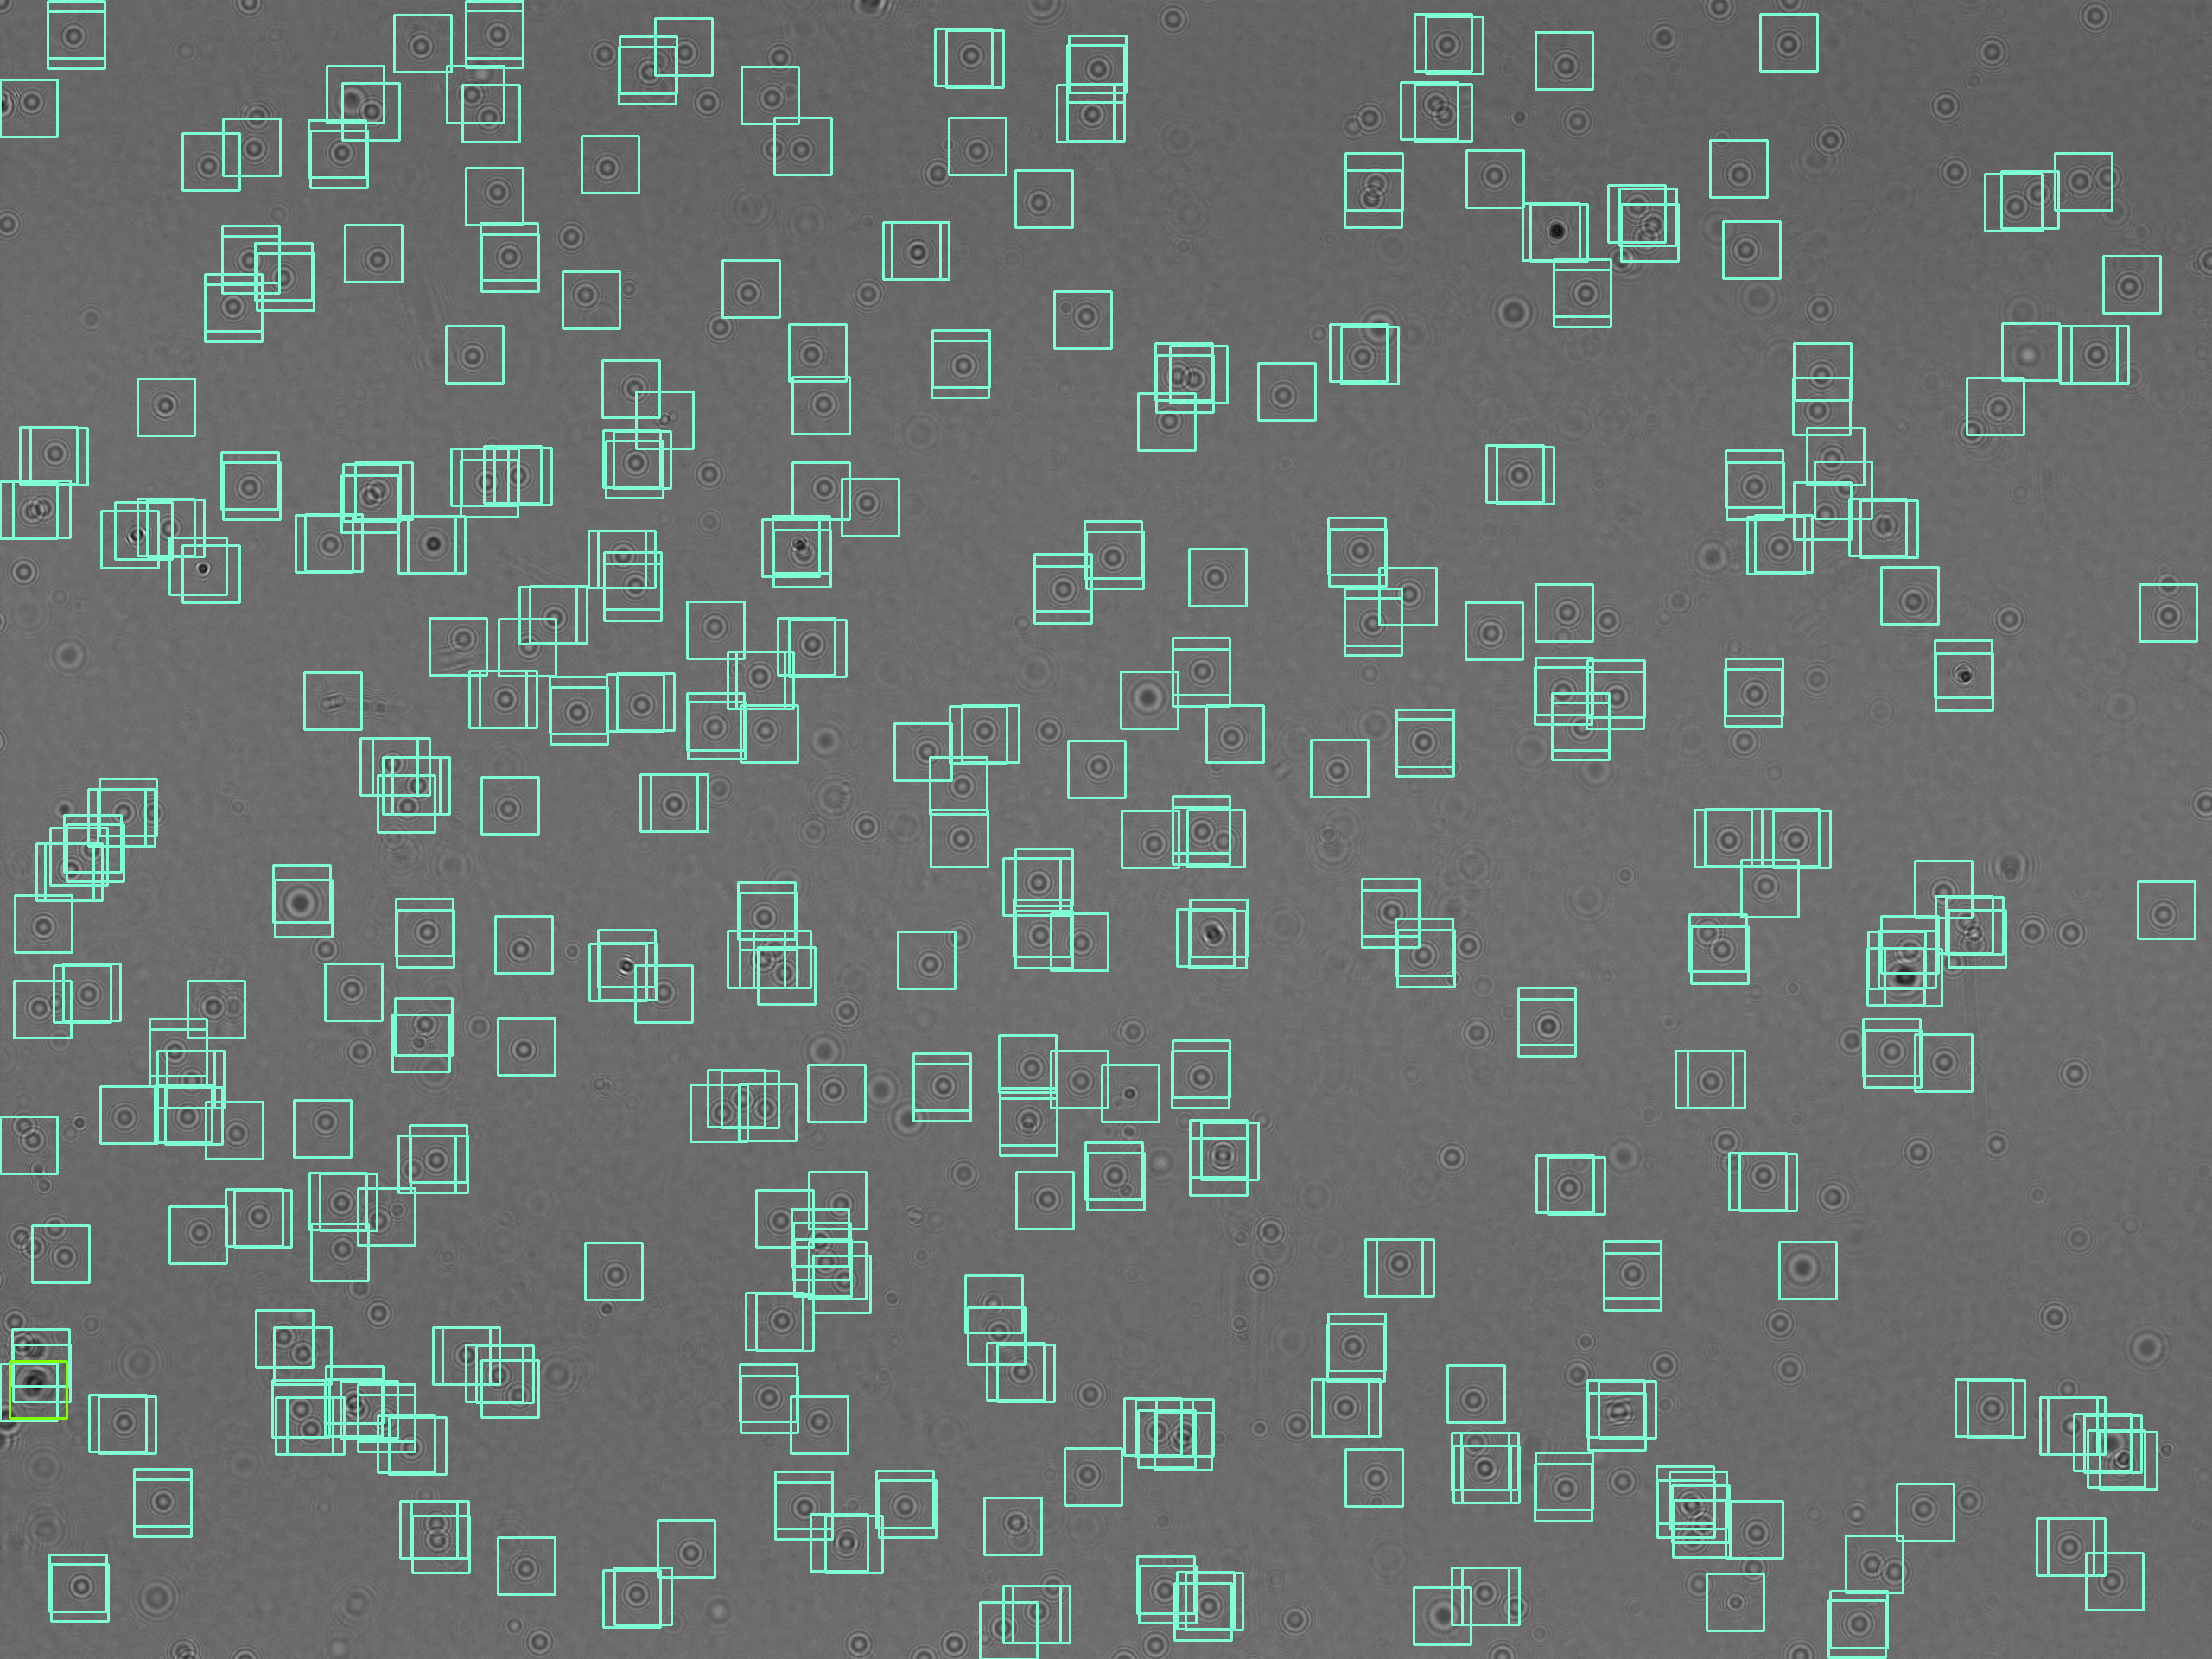

Analyzing Complete...


In [8]:
infer(input_imgname, DATA_FOLDER)